In [ ]:
!pip install konlpy # 코엔엘파이; 한국어 정보처리를 위한 파이썬 패키지. 
!pip install collections # 리스트, 튜플, 딕셔내리, 셋트 이외의 데이터형 구축 패키지
!pip install wordcloud # 아마도 워드 클라우딩 하는 패키지
!pip install sys # sys 모듈은 파이썬 인터프리터가 제공하는 변수와 함수를 직접 제어할 수 있게 해주는 모듈이다.

ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
ERROR: Could not find a version that satisfies the requirement sys (from versions: none)
ERROR: No matching distribution found for sys


In [42]:
import matplotlib.font_manager as fm

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]
font_list

['STIXSizeOneSym',
 'STIXSizeFiveSym',
 'DejaVu Serif Display',
 'STIXSizeTwoSym',
 'STIXNonUnicode',
 'DejaVu Serif',
 'STIXNonUnicode',
 'DejaVu Serif',
 'DejaVu Sans Mono',
 'cmtt10',
 'DejaVu Sans',
 'STIXNonUnicode',
 'cmb10',
 'DejaVu Sans',
 'STIXSizeFourSym',
 'STIXGeneral',
 'DejaVu Serif',
 'DejaVu Sans Mono',
 'cmsy10',
 'cmr10',
 'STIXNonUnicode',
 'DejaVu Serif',
 'STIXGeneral',
 'STIXSizeThreeSym',
 'DejaVu Sans Mono',
 'cmmi10',
 'STIXSizeOneSym',
 'STIXSizeFourSym',
 'STIXSizeThreeSym',
 'DejaVu Sans',
 'DejaVu Sans Mono',
 'STIXSizeTwoSym',
 'STIXGeneral',
 'DejaVu Sans',
 'cmex10',
 'DejaVu Sans Display',
 'cmss10',
 'STIXGeneral',
 'Liberation Mono',
 'Liberation Sans',
 'Liberation Sans',
 'Liberation Mono',
 'Humor Sans',
 'Liberation Serif',
 'Liberation Serif',
 'Liberation Serif',
 'Liberation Mono',
 'Liberation Sans Narrow',
 'Liberation Sans Narrow',
 'Liberation Mono',
 'Liberation Sans Narrow',
 'Liberation Sans',
 'Liberation Sans',
 'Liberation Sans Narro

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import sys
from konlpy.tag import Okt
from collections import Counter
from wordcloud import wordcloud

data=pd.read_csv('train.csv', encoding='utf-8')
data

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0
...,...,...,...
4995,4996,좋은 배우들로 3류영화를 찍은 안타까운 영화,0
4996,4997,진짜 드럽게 재미없다 에드워드 호퍼 그림에 배경 빼고는 볼게 아닌영화,0
4997,4998,가장 실망스러운 영화.. 지금까지 본영화중..,0
4998,4999,"이런 평점 테러, 네이버에서 좀 막아야 하는 것 아닌가?",1


In [ ]:
#3 결측값 확인
def check_missing_col(dataframe):
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):  # enumerate 반복시키는 내장함수
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'총 {missing_values}개의 결측치가 존재합니다.')

        if i == len(dataframe.columns) - 1 and counted_missing_col == 0:
            print('결측치가 존재하지 않습니다')
check_missing_col(data)



결측치가 존재하지 않습니다


In [ ]:
#8 리뷰길이 확인
str_len_mean = np.mean(data['document'].str.len()) # 리뷰 길이의 평균값 계산
print('리뷰의 평균 길이 :',str_len_mean)

리뷰의 평균 길이 : 27.1352


In [ ]:
#9.데이터 필터링을 위한 마스크 설정
mask_pos = (data.label == 1)
mask_neg = (data.label == 0)

#10.전체 / 긍정 / 부정 리뷰 집합을 설정.
df_train = data.document.copy() # 전체 train 데이터
df_pos = data.loc[mask_pos,:].document # 긍정 리뷰에만 해당하는 train 데이터
df_neg = data.loc[mask_neg,:].document # 부정 리뷰에만 해당하는 train 데이터

#11. 세 집합을 리스트로 묶기.
compare = [df_train, df_pos, df_neg]

#15 리뷰당 단어수(word) 확인하기 

word_split = data['document'].str.split() # 공백을 기준으로 문자열을 분리
# .stry객체의 문자정보를 추출 
word_split[:5] # 상위 5개 값 확인 , 처음부터 5까지 

#17 함수:전체 리뷰들을 하나의 문자열로 만듬
def df2str(df):
    
    s = [s for s in df]
    document = ""
    for i in range(len(s)):
        document += s[i]
    return document
#18 함수: 명사추출하기 
def get_noun(text):
   
    okt = Okt()
    noun = okt.nouns(text)
    for i,v in enumerate(noun):
        if len(v)<2:
            noun.pop(i)
    count = Counter(noun)
    noun_list = count.most_common(100)

    return noun_list

#19  함수:워드클라우드 이미지 생성하기
def visualize(noun_list, title):
    # 워드클라우드 이미지 생성
    wc= WordCloud(
        font_path = 'a고딕13.ttf',    # 한글폰트 경로 설정
        background_color='white',                             # 배경 색깔 정하기
        colormap = 'Dark2',                                # 폰트 색깔 정하기
        width = 800,
        height = 800).generate_from_frequencies(dict(noun_list)) 
    
    plt.figure(figsize=(10,10)) #이미지 사이즈 지정
    plt.suptitle("Word Cloud", fontsize=40)
    plt.title(title, fontsize=20)
    plt.imshow(wc, interpolation='lanczos') #이미지의 부드럽기 정도
    plt.axis('off') #x y 축 숫자 제거
    plt.show()  # 워드클라우드 이미지 확인
    
    return wc

In [ ]:
# 전체 훈련데이터 워드 클라우드 형성
document = df2str(df_train) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:5] # 상위 5개 단어 확인

[('영화', 1501), ('정말', 320), ('진짜', 269), ('최고', 220), ('평점', 185)]

In [ ]:
import matplotlib.font_manager as fm

# 설치된 폰트 출력
font_list = [font.name for font in fm.fontManager.ttflist]
font_list

['STIXSizeOneSym',
 'STIXSizeFiveSym',
 'DejaVu Serif Display',
 'STIXSizeTwoSym',
 'STIXNonUnicode',
 'DejaVu Serif',
 'STIXNonUnicode',
 'DejaVu Serif',
 'DejaVu Sans Mono',
 'cmtt10',
 'DejaVu Sans',
 'STIXNonUnicode',
 'cmb10',
 'DejaVu Sans',
 'STIXSizeFourSym',
 'STIXGeneral',
 'DejaVu Serif',
 'DejaVu Sans Mono',
 'cmsy10',
 'cmr10',
 'STIXNonUnicode',
 'DejaVu Serif',
 'STIXGeneral',
 'STIXSizeThreeSym',
 'DejaVu Sans Mono',
 'cmmi10',
 'STIXSizeOneSym',
 'STIXSizeFourSym',
 'STIXSizeThreeSym',
 'DejaVu Sans',
 'DejaVu Sans Mono',
 'STIXSizeTwoSym',
 'STIXGeneral',
 'DejaVu Sans',
 'cmex10',
 'DejaVu Sans Display',
 'cmss10',
 'STIXGeneral',
 'Liberation Mono',
 'Liberation Sans',
 'Liberation Sans',
 'Liberation Mono',
 'Humor Sans',
 'Liberation Serif',
 'Liberation Serif',
 'Liberation Serif',
 'Liberation Mono',
 'Liberation Sans Narrow',
 'Liberation Sans Narrow',
 'Liberation Mono',
 'Liberation Sans Narrow',
 'Liberation Sans',
 'Liberation Sans',
 'Liberation Sans Narro

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47568 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_

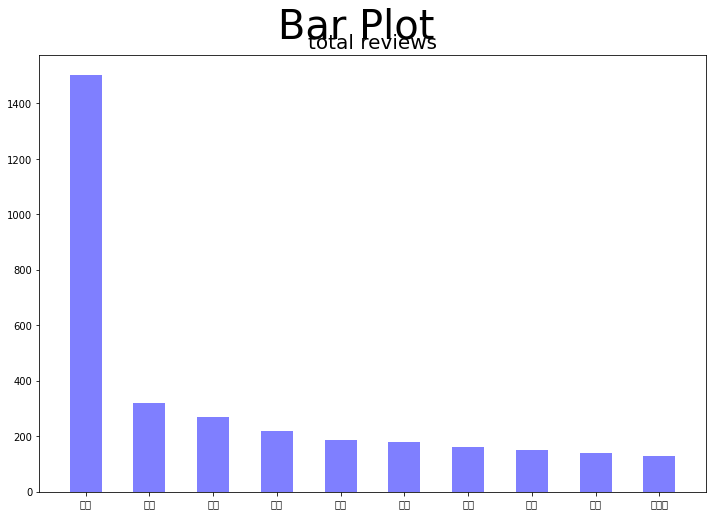

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline
rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False


plt.rc('font', family='AppleGothic') 
top_10 = dict(noun_list[:10]) # 추출한 명사 중 상위 10개
plt.figure(figsize=(10,7.5))
plt.suptitle("Bar Plot", fontsize=40)
plt.title('total reviews', fontsize=20)
plt.bar(top_10.keys(), top_10.values(), width=0.5, color='b', alpha=0.5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()